# Li-Cor Li-200R Transimpedance Amplifier Calculations
This notebook contains the information and calculations uesd to design the transimpedance amplifier used to convert the current output of the Li-200R Pyranometer to a voltage output readable by an ADC. The work here is more for testing and prototyping, the Excel workbook `Constants.xslx` is used to store the values. For this application, Excel is easier to read and budget with than a jupyter notebook.

## Assumptions and initial values
* According to [Newport](https://www.newport.com/introduction-to-solar-radiation), the maximum incoming solar radiation on a horizontal surface at ground level is $1120 W/m^2$. From experience, Dr. Pardyjak advised using a value of $1200 W/m^2$.
* The supply voltage is 5V, but the max input for the ADC is 4.096V
* The rails are at most 100mV away from the supply. The datasheet indicates differently but this is the starting assumption. However, since the supply voltage is well above the ADC max input, the rail offset is considered to be 0.
* The ADC used to read is 15-bit
* Information about feedback capacitor selection was found [here](http://www.planetanalog.com/document.asp?doc_id=527534) and [here](https://en.wikipedia.org/wiki/Transimpedance_amplifier).

## Transimpedance Amplifier
![Li-200R Transimpedance Amplifer](Li200-Transimpedance-Amplifier.png)

The schematic above will be used in the analysis of the amplifier behavior. The three rules of ideal op-amp behavior will be used:
1. The op-amp output can source infinite current
2. The voltage at the two inputs to the op-amp are identical
3. There resistance at the two inputs of the op-amp is infinite; no current can flow into the inputs of the op-amp

The analysis is as follows:

1. The voltage at V2 is 0, so the voltage at V1 is 0
2. The current through R1 is identical to the current through the Li-200R. This is written as $I_{R1} = I_{Li-200R}$
3. The current through R1 is $I_{R1} = \frac{V3 - V1}{R1} = \frac{V3 - 0}{R1} = V3/R1$
4. The nominal current through the Li-200R is listed above and equal to the current through R1: $I_{R1} = I_{Li-200R} = V3/R1$
5. The desired voltage at the output of the amplifier is $V3 = I_{Li-200R}*R1$. In other words, the gain of the amplifier is equal to value of $R1$, so $R1$ is chosen by $V3/I_{Li-200R}$.

The following code calculates the values required, accounting for a "safety factor" so the amplifier doesn't rail. 

*Note: The above schematic doesn't show the 0.1$\mu$F bypass capacitor on VDD*

In [20]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
%matplotlib inline

def resistorFind(calConst, maxSunlight=1200, supplyV=4.096, railOffset=0.00):
    """
    Given a pyranometer calibration constant, finds the resistor that produces the desired gain
    in the transimpedance amplifier
    Inputs:
        calConst: The calibration constant for the sensor. Should be input in A/(Wm^-2) (e.g. 92.54e-6/1000)
        maxSunlight: Maximum sunlight expected. Shouldn't need to change but the option is there. In Wm^-2
        supplyV: The voltage rail for the op-amp. In Volts
        railOffset: The opamp rail offset. Somewhat hard to determine but there in case. Enter in Volts
    Output:
        R: Amplifying resistor. In ohms  
    """
    I = calConst                   # Current/(Unit Sunlight) (A/(Wm^-2))
    IMax = I*maxSunlight           # Maximum current expected around world (A)
    V3 = supplyV - railOffset      # Maximum voltage expected from op-amp (V)
    R = V3/IMax                    # Resistor required to get maximum voltage with maximum sunlight (Ohm)
    return R

def maxVoltFind(calConst, resistorVal, maxSunlight=1200):
    """
    Given a pyranometer calibration constant and a resistor value, finds the maximum expected voltage from
    the transimpedance amplifier
    Inputs:
        calConst: The calibration constant for the sensor. Should be input in A/(Wm^-2) (e.g. (92.54e-6 A)/(1000Wm^-2)
        resistorVal: The amplifying resistor value. In ohms
        maxSunlight: Maximum sunlight expected. Shouldn't need to change but the option is there. In Wm^-2
    Output:
        vMax: Maximum voltage expected
    """
    I = calConst                   # Current/(Unit Sunlight) (A/(Wm^-2))
    IMax = I*maxSunlight           # Maximum current expected around world (A)
    vMax = IMax*resistorVal        # Maximum voltage expected (V)
    return vMax
    

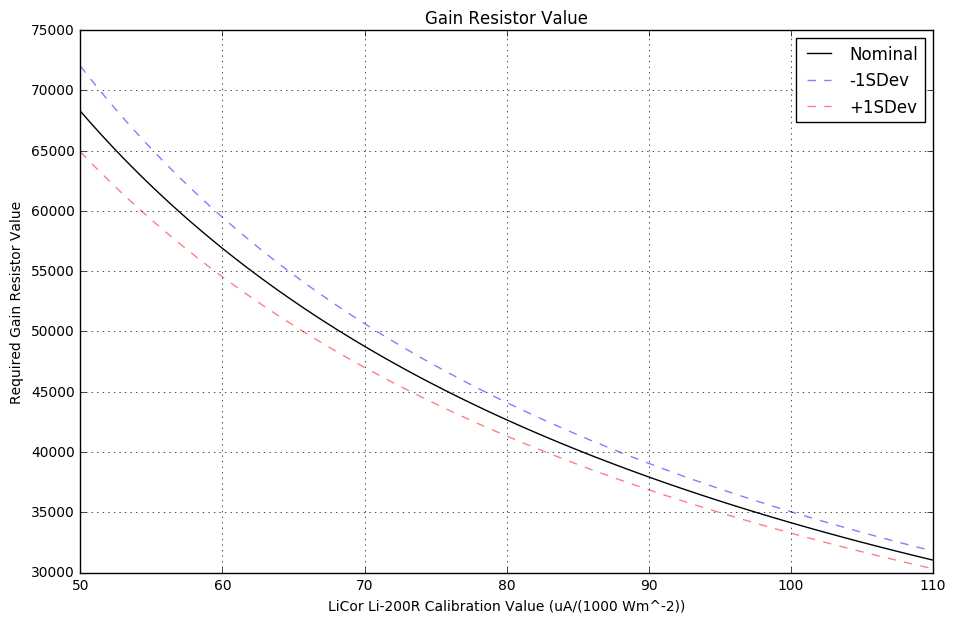

In [21]:
# Initialize Variables
liSDev = 2.6e-6/1000  # A/(Wm^-2)
mI = np.arange(50e-6,110e-6,0.5e-6)/1000  # Nominal current values - A/(Wm^-2)
lI = mI - liSDev                 # One standard deviation less than nominal
hI = mI + liSDev                 # One standard deviation greater than nominal

# Find resistances
mR = resistorFind(calConst=mI)
lR = resistorFind(calConst=lI)
hR = resistorFind(calConst=hI)

# Plot
plt.figure(figsize=(11,7))
plt.xlabel('LiCor Li-200R Calibration Value (uA/(1000 Wm^-2))')
plt.ylabel('Required Gain Resistor Value')
plt.title('Gain Resistor Value')
plt.plot(mI*1000*1e6, mR, '-', color='k', alpha=1.0, label='Nominal')
plt.plot(mI*1000*1e6, lR, '--', color='b', alpha=0.5, label='-1SDev')
plt.plot(mI*1000*1e6, hR, '--', color='r', alpha=0.5, label='+1SDev')
plt.grid(True)
plt.legend()
plt.show()

In [22]:
# Initialize Data Here - Enter units in A/(Wm^-2)
constants = {}
constants["PY80043"] = 92.54e-6/1000
constants["PY80046"] = 90.07e-6/1000
constants["PY80042"] = 86.06e-6/1000
constants["PY75566"] = 102.25e-6/1000
constants["PY103188"] = 58.3e-6/1000
constants["PY103189"] = 54.93e-6/1000
constants["PY103190"] = 57.01e-6/1000
constants["PY103191"] = 56.89e-6/1000
constants["PY103192"] = 57.17e-6/1000
constants["PY103193"] = 52.58e-6/1000
constants["PY103194"] = 57.80e-6/1000
constants["PY103195"] = 59.95e-6/1000

# Create Data Frame
pyFrame = pd.DataFrame.from_dict(constants, orient='index')
pyFrame.columns = ['Calibration Const']
pyFrame.sort_index(ascending=True, inplace=True)

In [23]:
# Find Ideal Resistor to amplify to 4.096V
pyFrame["Ideal Resistor"] = pyFrame["Calibration Const"].apply(resistorFind)
pyFrame

,Calibration Const,Ideal Resistor
PY103188,5.830000e-08,58547.741567
PY103189,5.493000e-08,62139.692943
PY103190,5.701000e-08,59872.536982
PY103191,5.689000e-08,59998.828148
PY103192,5.717000e-08,59704.973471
PY103193,5.258000e-08,64916.951946
PY103194,5.780000e-08,59054.209919
PY103195,5.995000e-08,56936.335835
PY75566,1.022500e-07,33382.233089
PY80042,8.606000e-08,39662.251143
